In [2]:
import numpy as np
import pandas as pd
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Torch
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torch.nn as nn

from math import ceil


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Resize the image and do a center crop, and store them on a tensor
import torchvision.transforms as transforms
img_size = (224, 224)
batch_size=32
train_data_dir = '/content/drive/MyDrive/brain/Training'
test_data_dir = '/content/drive/MyDrive/brain/Testing'

#preprocessing : standardizing the sizes
#datsets and dataloaders
transform = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_data_dir,transform=transform)

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

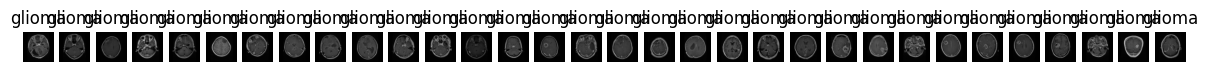

In [8]:
images, labels = next(iter(test_loader))

# Plot the images in a grid
num_images = len(images)
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i in range(num_images):
    image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to NumPy array and permute dimensions
    label =test_dataset.classes[labels[i]]     # Get the label corresponding to the index

    axes[i].imshow(image)
    axes[i].set_title(label)
    axes[i].axis('off')

plt.show()

**VGG implementation**

In [9]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [10]:
def train(model, train_loader, test_loader, training_name, saved_weights_dir, epochs, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for batch_number, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')

        epoch_loss /= len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')

        model.eval()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss /= len(test_loader)
        epoch_acc = correct / total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
        savedDir = f'{saved_weights_dir}/{training_name}_epoch_{epoch}.pth'
        torch.save(model.state_dict(), savedDir)
        print(f'Saved weights to {savedDir}')

    return train_losses, train_accuracies, test_losses, test_accuracies


In [20]:
def plot_graph(train_acc, test_acc):
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy vs. Epochs')
    plt.legend()
    plt.show()

In [21]:
def plot_loss_graph(train_loss, test_loss):
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
    plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss vs. Epochs')
    plt.legend()
    plt.show()

In [17]:
model = VGG16(num_classes=4).to(device)
print(model)
training_name="vgg"
saved_weights_dir="/content/drive/MyDrive/vgg"
max_epochs=15

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

**Model 1**

In [18]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     train_loader, \
                                                                     test_loader, \
                                                                     training_name= training_name,\
                                                                     saved_weights_dir=saved_weights_dir,\
                                                                     epochs = max_epochs, \
                                                                     lr = 1e-3)

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.28125
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.28125
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.25
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.2265625
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.2125
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.23958333333333334
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.2544642857142857
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.2578125
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.2569444444444444
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.278125
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.2897727272727273
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.2942708333333333
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.2980769230769231
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.29910714285714285
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.30833333333333335
Epoch 1/15, Batch number: 15, Cumulated accuracy

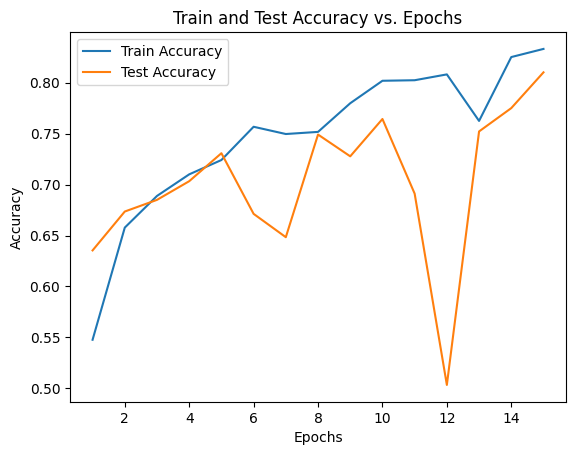

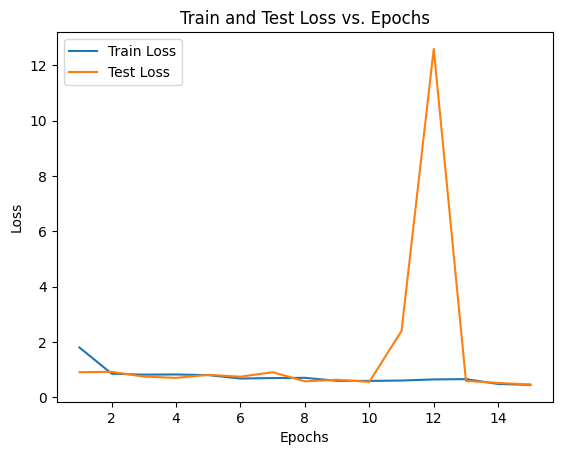

In [22]:
plot_graph(train_accuracies, test_accuracies)
plot_loss_graph(train_losses, test_losses)

Model 2, decrease the learning rate

In [23]:
model = VGG16(num_classes=4).to(device)
training_name="vgg"
saved_weights_dir="/content/drive/MyDrive/vgg/Model2"
max_epochs=15

In [24]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     train_loader, \
                                                                     test_loader, \
                                                                     training_name= training_name,\
                                                                     saved_weights_dir=saved_weights_dir,\
                                                                     epochs = max_epochs, \
                                                                     lr = 1e-4)

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.1875
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.28125
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.21875
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.25
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.30625
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.3489583333333333
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.38392857142857145
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.39453125
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.4027777777777778
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.415625
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.42329545454545453
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.4322916666666667
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.42788461538461536
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.4174107142857143
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.41041666666666665
Epoch 1/15, Batch number: 15, Cumulated accuracy

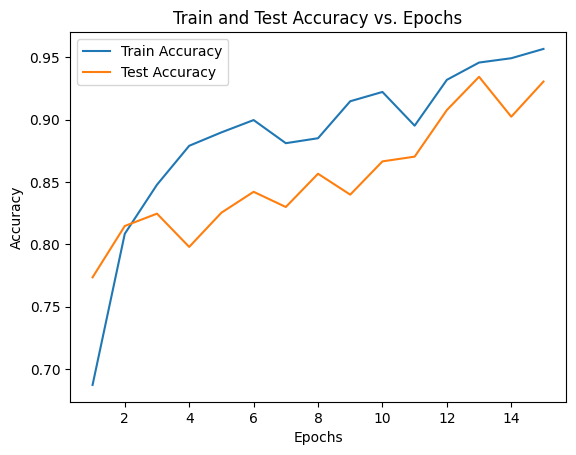

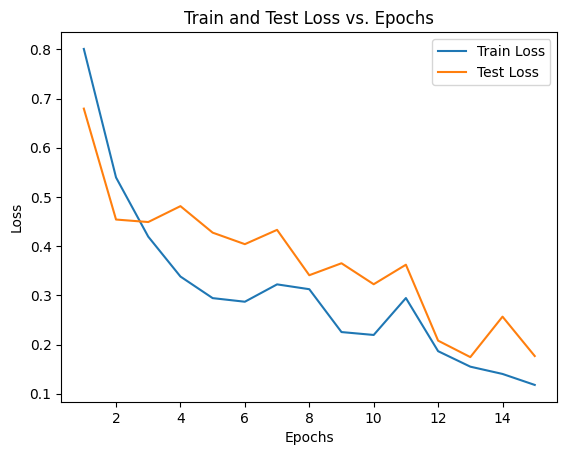

In [25]:
plot_graph(train_accuracies, test_accuracies)
plot_loss_graph(train_losses, test_losses)

**Model 3** : AvgPool2d, lr= 1e-4

In [30]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [33]:
model = VGG16(num_classes=4).to(device)
print(model)
training_name="vggAVG"
saved_weights_dir="/content/drive/MyDrive/vgg/Model3"
max_epochs=15

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer5): Sequential(
    (0): Conv2d(128, 25

In [34]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     train_loader, \
                                                                     test_loader, \
                                                                     training_name= training_name,\
                                                                     saved_weights_dir=saved_weights_dir,\
                                                                     epochs = max_epochs, \
                                                                     lr = 1e-4)

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.1875
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.21875
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3125
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.3125
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.36875
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.3802083333333333
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.41964285714285715
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.44140625
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.4513888888888889
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.465625
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.4602272727272727
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.4635416666666667
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.46153846153846156
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.45535714285714285
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.46458333333333335
Epoch 1/15, Batch number: 15, Cumulated accurac

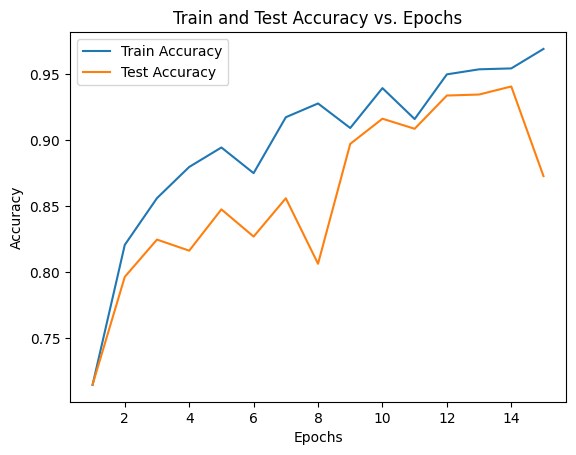

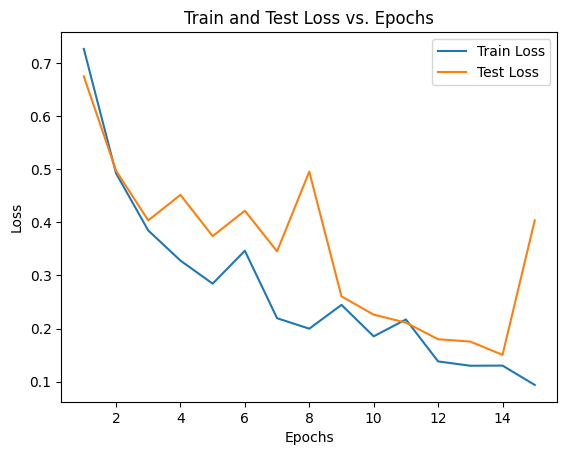

In [35]:
plot_graph(train_accuracies, test_accuracies)
plot_loss_graph(train_losses, test_losses)

**Model 4** : AvgPool2d, lr= 1e-3

In [36]:
model = VGG16(num_classes=4).to(device)
training_name="vggAVG"
saved_weights_dir="/content/drive/MyDrive/vgg/Model4"
max_epochs=15

In [37]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     train_loader, \
                                                                     test_loader, \
                                                                     training_name= training_name,\
                                                                     saved_weights_dir=saved_weights_dir,\
                                                                     epochs = max_epochs, \
                                                                     lr = 1e-3)

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.15625
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.1875
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.19791666666666666
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.15625
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.15
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.16666666666666666
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.1875
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.19921875
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.22569444444444445
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.225
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.23863636363636365
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.2630208333333333
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.2668269230769231
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.27232142857142855
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.2875
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.296875
Epoc

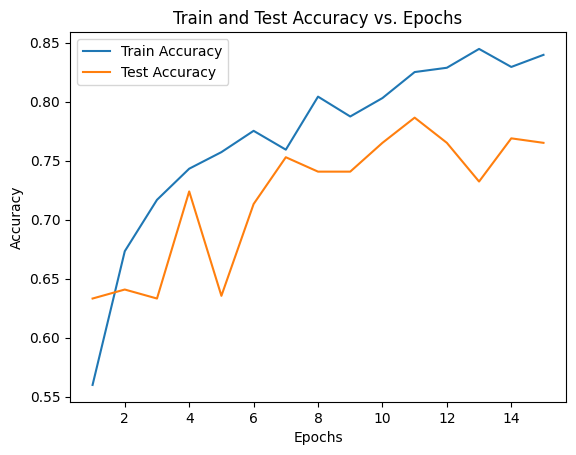

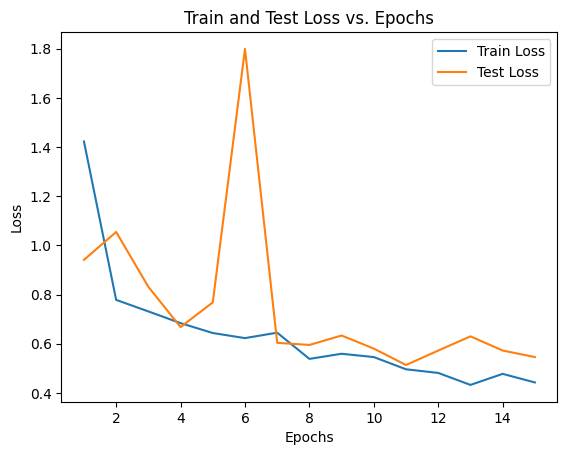

In [38]:
plot_graph(train_accuracies, test_accuracies)
plot_loss_graph(train_losses, test_losses)

**Model 5** : LPPool2d, lr= 1e-3

In [45]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.LPPool2d(2, kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.LPPool2d(2, kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.LPPool2d(2, kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.LPPool2d(2, kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.LPPool2d(2, kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [46]:
model = VGG16(num_classes=4).to(device)
training_name="vgglp"
saved_weights_dir="/content/drive/MyDrive/vgg/Model5"
max_epochs=15

In [47]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     train_loader, \
                                                                     test_loader, \
                                                                     training_name= training_name,\
                                                                     saved_weights_dir=saved_weights_dir,\
                                                                     epochs = max_epochs, \
                                                                     lr = 1e-3)

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.3125
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.28125
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3125
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.3125
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.3125
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.3072916666666667
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.30357142857142855
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.296875
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.2986111111111111
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.290625
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.3039772727272727
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.296875
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.2932692307692308
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.31473214285714285
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.325
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.33203125
Epoch 1/15, Ba

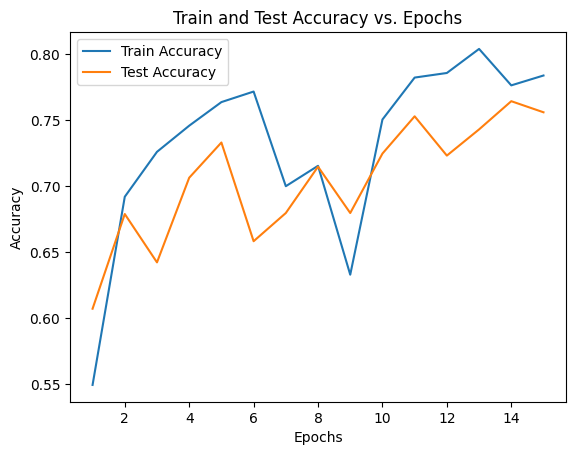

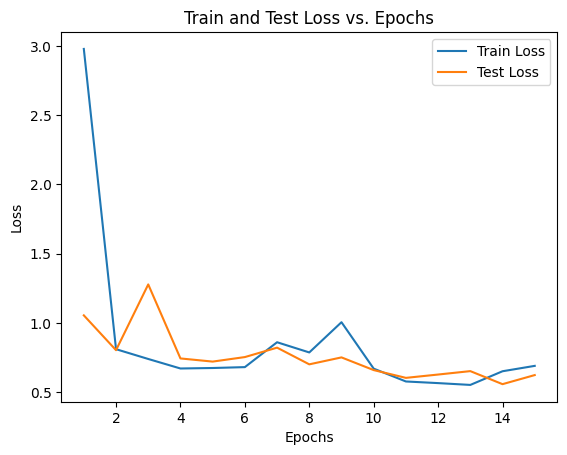

In [49]:
plot_graph(train_accuracies, test_accuracies)
plot_loss_graph(train_losses, test_losses)

**Model 6** : LPPool2d, lr= 1e-4

In [51]:
model = VGG16(num_classes=4).to(device)
training_name="vgglp1"
saved_weights_dir="/content/drive/MyDrive/vgg/Model6"
max_epochs=15

In [52]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     train_loader, \
                                                                     test_loader, \
                                                                     training_name= training_name,\
                                                                     saved_weights_dir=saved_weights_dir,\
                                                                     epochs = max_epochs, \
                                                                     lr = 1e-4)

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.3125
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.390625
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.4375
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.4140625
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.4125
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.4479166666666667
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.4642857142857143
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.48828125
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.4722222222222222
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.46875
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.4715909090909091
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.4947916666666667
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.5072115384615384
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.5066964285714286
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.5083333333333333
Epoch 1/15, Batch number: 15, Cumulated accuracy:

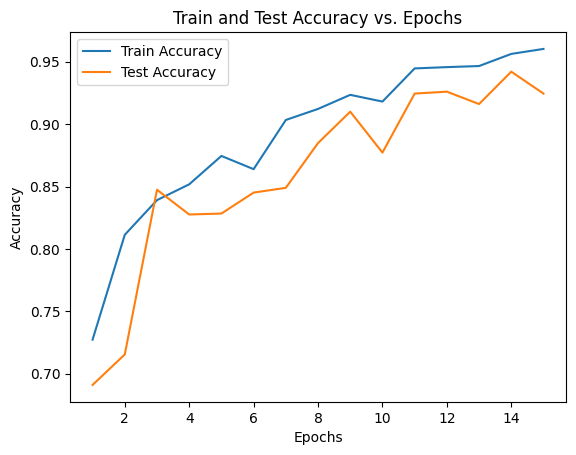

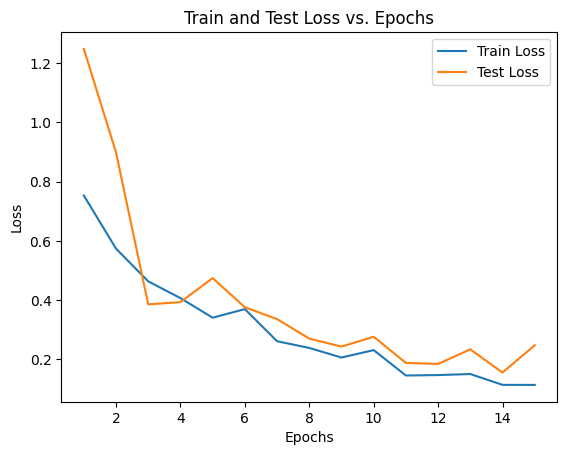

In [53]:
plot_graph(train_accuracies, test_accuracies)
plot_loss_graph(train_losses, test_losses)